In [126]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
%matplotlib inline
from skimage import io
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit 
from mpl_toolkits import mplot3d
from scipy import misc 
%config InlineBackend.figure_formats = {'png', 'retina'}

# K-Means

In [2]:
# To compress a image, use the syntax ImgCompress('image.ppm', 32, 10)

def KmeansCompress(name, k, steps):
    image = io.imread(name)
    io.imshow(image)
    io.show()
    
    image_ready = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    m, n = image_ready.shape
        
    cluster_centers=np.zeros((k,n))
    for i in range(n):
        cluster_centers[:,i]=256*np.random.random(size=k)
    
    iteration=[]
    for m in range(steps):       
        distance=np.zeros((len(cluster_centers), len(image_ready)))
        
        for i in range(len(cluster_centers)):
            for j in range(len(image_ready)):
                distance[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(cluster_centers[i], image_ready[j])]))
                
        distance=pd.DataFrame(distance)  
        
        flag=np.zeros(len(image_ready))
        for i in range(len(image_ready)):
            flag[i]=distance[i].idxmin()
        iteration.append(flag)
            
        for i in range(len(cluster_centers)):
            xs, ys, zs, enum = 0, 0, 0, 0
            for j in range(len(image_ready)):
                if flag[j]==i:
                    xs+=image_ready[j,0]
                    ys+=image_ready[j,1]
                    zs+=image_ready[j,2]
                    enum+=1
            if enum!=0:
                cluster_centers[i,0]=xs/enum
                cluster_centers[i,1]=ys/enum
                cluster_centers[i,2]=zs/enum
            if enum==0:
                enum=1
                
    flag_image=flag.reshape(image.shape[0], image.shape[1])
    compressed=[]
    for i in flag_image:
        for j in i:
            compressed.append(cluster_centers[int(j)])
            
    compressed=np.array(compressed)
    compressed_ready=compressed
    compressed=compressed.reshape(image.shape[0], image.shape[1], image.shape[2]).astype(np.uint8)
    
    io.imshow(compressed) 
    io.show() 
        
    diff=image_ready-compressed_ready
    rmse = np.sqrt((np.square(diff)).mean(axis=None))
    print(rmse)
    # saving the compressed image. 
    misc.imsave('kmeans_' + str(k) + '_error_'+ str(int(rmse))+ '_' + str(name), compressed) 

# Winner Take All Clustering

In [3]:
def wtaCompress(name, k, epsilon):
    image = io.imread(name)
    io.imshow(image)
    io.show()

    image_ready = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    m, n = image_ready.shape
    
    cluster_centers=np.zeros((k,n))
    for i in range(n):
        cluster_centers[:,i]=256*np.random.random(size=k)
    
    for z in range(5):
        iteration=np.zeros(len(image_ready))
        for j in range(m):
            distance=np.zeros(len(cluster_centers))    
            for i in range(len(cluster_centers)):
                distance[i]=np.sqrt(sum([(a - b)**2 for a, b in zip(cluster_centers[i], image_ready[j])]))
                    
            distance=pd.DataFrame(distance)  
            flag=distance.idxmin()
            iteration[j]=flag[0]
            for i in range(len(cluster_centers)):  
                if flag[0]==i:
                    cluster_centers[i,0]+=epsilon*(image_ready[j,0]-cluster_centers[i,0])
                    cluster_centers[i,1]+=epsilon*(image_ready[j,1]-cluster_centers[i,1])
                    cluster_centers[i,2]+=epsilon*(image_ready[j,2]-cluster_centers[i,2])
                        
    flag_image=iteration.reshape(image.shape[0], image.shape[1])
    compressed=[]
    for i in flag_image:
        for j in i:
            compressed.append(cluster_centers[int(j)])
            
    compressed=np.array(compressed)
    compressed_ready=compressed
    compressed=compressed.reshape(image.shape[0], image.shape[1], image.shape[2]).astype(np.uint8)
    
    io.imshow(compressed) 
    io.show() 
    
    diff=image_ready-compressed_ready
    rmse = np.sqrt((np.square(diff)).mean(axis=None))
    print(rmse)
    # saving the compressed image. 
    misc.imsave('wta_' + str(k) + '_error_'+ str(int(rmse))+ '_' + str(name), compressed) 

# Kohonen (SOM) Map

In [4]:
def SomCompress(name, k):
    epsilon_min=0.01
    epsilon_max=0.1
    sigma=5.   
    image = io.imread(name)
    io.imshow(image)
    io.show()

    image_ready = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    m, n = image_ready.shape
    
    cluster_centers=np.zeros((k,n))
    for i in range(n):
        cluster_centers[:,i]=256*np.random.random(size=k)
    
    for z in range(5):
        iteration=np.zeros(len(image_ready))
        for j in range(m): # m is the Kmax as in Kohonen
            epsilon=epsilon_max*(epsilon_min/epsilon_max)**(j/m) #epsilon_k
            
            distance=np.zeros(len(cluster_centers))    
            for i in range(len(cluster_centers)):
                distance[i]=np.sqrt(sum([(a - b)**2 for a, b in zip(cluster_centers[i], image_ready[j])]))

            distance=pd.DataFrame(distance)  
            flag=distance.idxmin()
            iteration[j]=flag[0]
            for i in range(len(cluster_centers)):
                phi=np.exp(-(np.linalg.norm(cluster_centers[i]-cluster_centers[flag[0]])**2)/(2*sigma**2))
                
                cluster_centers[i,0]+=epsilon*phi*(image_ready[j,0]-cluster_centers[i,0])
                cluster_centers[i,1]+=epsilon*phi*(image_ready[j,1]-cluster_centers[i,1])
                cluster_centers[i,2]+=epsilon*phi*(image_ready[j,2]-cluster_centers[i,2])
  
    flag_image=iteration.reshape(image.shape[0], image.shape[1])
    compressed=[]
    for i in flag_image:
        for j in i:
            compressed.append(cluster_centers[int(j)])
            
    compressed=np.array(compressed)
    compressed_ready=compressed
    compressed=compressed.reshape(image.shape[0], image.shape[1], image.shape[2]).astype(np.uint8)
    
    io.imshow(compressed) 
    io.show() 
    
    diff=image_ready-compressed_ready
    rmse = np.sqrt((np.square(diff)).mean(axis=None))
    print(rmse)
    # saving the compressed image. 
    misc.imsave('kohonen_' + str(k) + '_error_'+ str(int(rmse))+ '_' + str(name), compressed) 

# K-means with Meanshift

In [5]:
# To compress a image, use the syntax ImgCompress('image.ppm', 32, 10)
import numpy as np 
import pandas as pd 
from sklearn.cluster import MeanShift 

def ShiftCompress(name, steps):
    image = io.imread(name)
    io.imshow(image)
    io.show()
    
    image_ready = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    m, n = image_ready.shape
    
    ms = MeanShift(bandwidth=20) 
    ms.fit(image_ready) 
    cluster_centers = ms.cluster_centers_ 
    
    iteration=[]
    for m in range(steps):       
        distance=np.zeros((len(cluster_centers), len(image_ready)))
        
        for i in range(len(cluster_centers)):
            for j in range(len(image_ready)):
                distance[i][j]=np.sqrt(sum([(a - b)**2 for a, b in zip(cluster_centers[i], image_ready[j])]))
                
        distance=pd.DataFrame(distance)  
        
        flag=np.zeros(len(image_ready))
        for i in range(len(image_ready)):
            flag[i]=distance[i].idxmin()
        iteration.append(flag)
            
        for i in range(len(cluster_centers)):
            xs, ys, zs, enum = 0, 0, 0, 0
            for j in range(len(image_ready)):
                if flag[j]==i:
                    xs+=image_ready[j,0]
                    ys+=image_ready[j,1]
                    zs+=image_ready[j,2]
                    enum+=1
            if enum!=0:
                cluster_centers[i,0]=xs/enum
                cluster_centers[i,1]=ys/enum
                cluster_centers[i,2]=zs/enum
            if enum==0:
                enum=1
                
    flag_image=flag.reshape(image.shape[0], image.shape[1])
    compressed=[]
    for i in flag_image:
        for j in i:
            compressed.append(cluster_centers[int(j)])
            
    compressed=np.array(compressed)
    compressed_ready=compressed
    compressed=compressed.reshape(image.shape[0], image.shape[1], image.shape[2]).astype(np.uint8)
    
    io.imshow(compressed) 
    io.show() 
        
    diff=image_ready-compressed_ready
    rmse = np.sqrt((np.square(diff)).mean(axis=None))
    print(rmse)
    # saving the compressed image. 
    misc.imsave('meanshift_' + '_error_'+ str(int(rmse))+ '_' + str(name), compressed) 

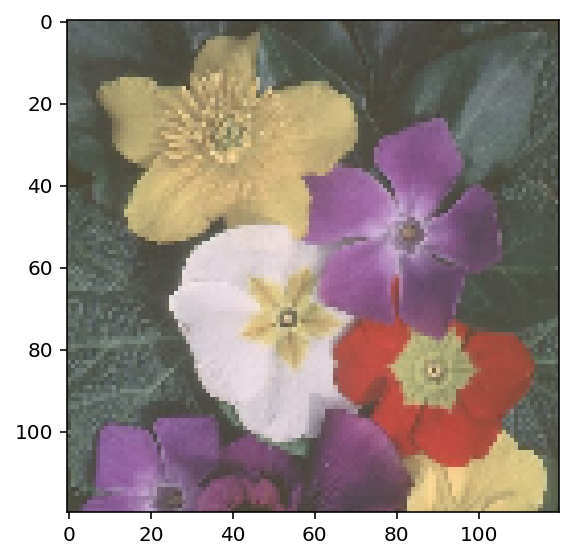

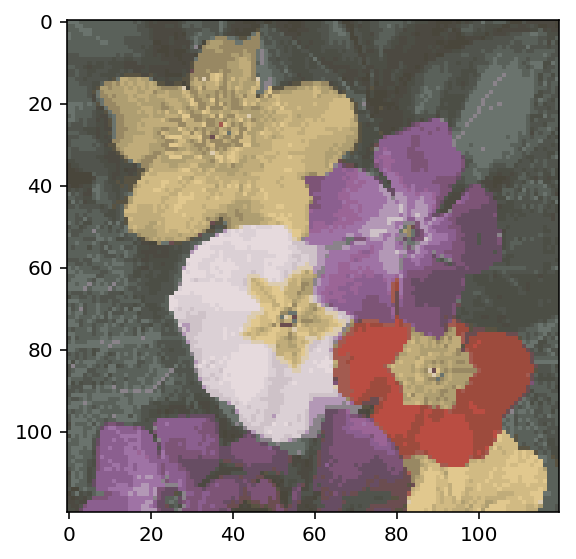

6.150313309441926
Elapsed time : 62.40922745701391


/Users/Yadu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:62: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [291]:
import timeit
start_time = timeit.default_timer()
#Code to Find the run time for#

KmeansCompress('flowersm.ppm', 91, 5)   # ImgCompress('image.ppm', 32, 10)

elapsed = timeit.default_timer() - start_time
print('Elapsed time :',elapsed)

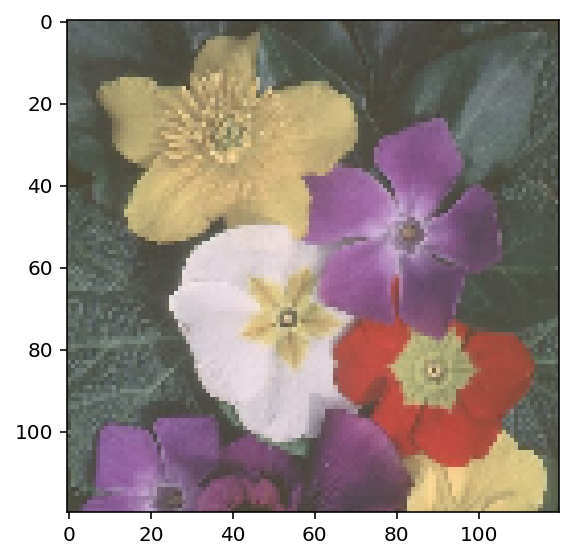

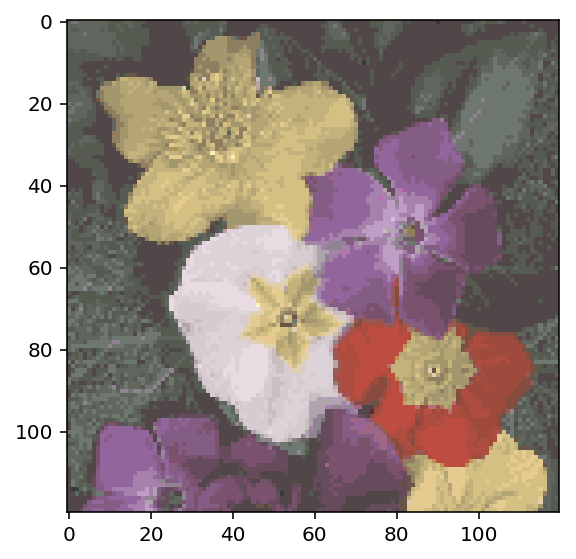

6.222284957377605
Elapsed time : 335.4943420520285


/Users/Yadu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [273]:
import timeit
start_time = timeit.default_timer()
#Code to Find the run time for#

wtaCompress('flowersm.ppm', 256, 0.01) # wtaCompress('image.ppm', 0.01)

elapsed = timeit.default_timer() - start_time
print('Elapsed time :',elapsed)

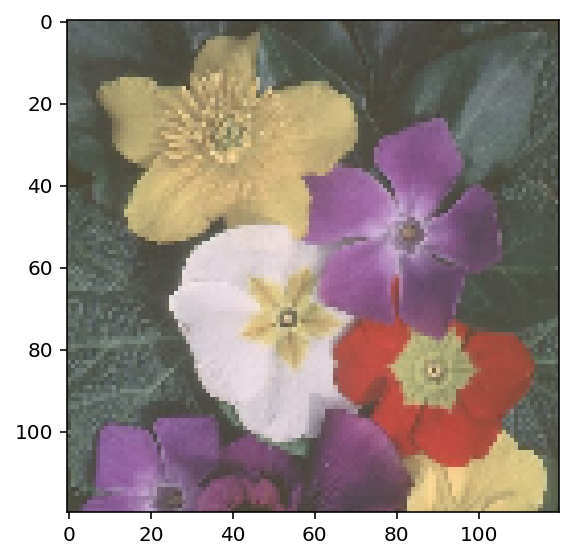

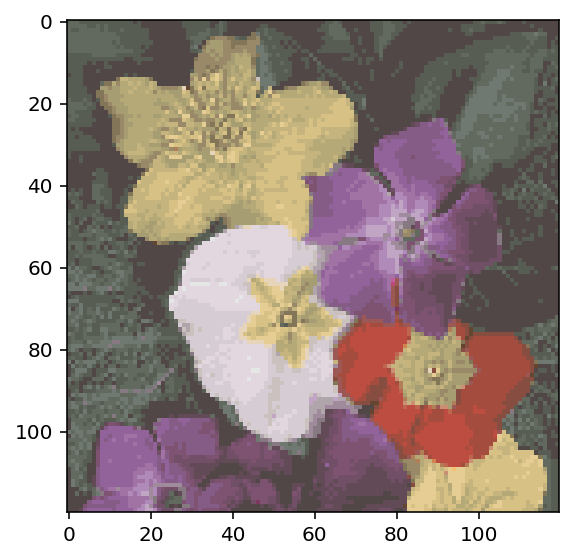

6.3240868631167135
Elapsed time : 1210.9856060149614


/Users/Yadu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [274]:
import timeit
start_time = timeit.default_timer()
#Code to Find the run time for#

SomCompress('flowersm.ppm', 256)  # SomCompress('image.ppm', 256)

elapsed = timeit.default_timer() - start_time
print('Elapsed time :',elapsed)

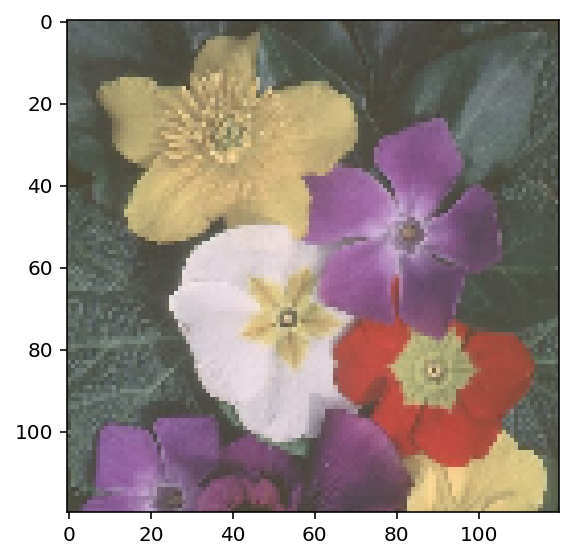

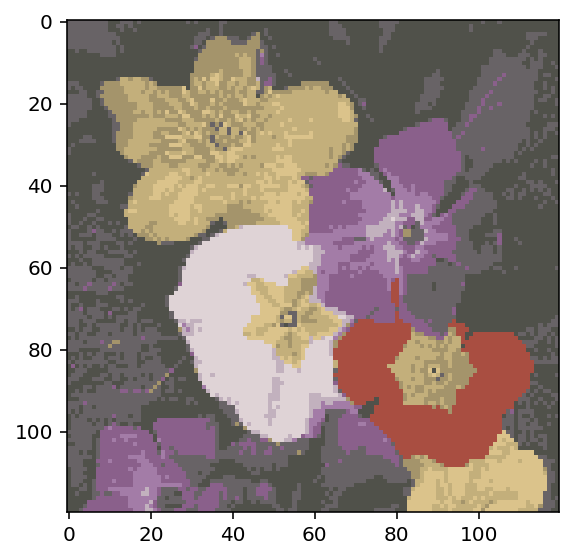

9.91742556034444
Elapsed time : 144.34023801703006


/Users/Yadu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [289]:
import timeit
start_time = timeit.default_timer()
#Code to Find the run time for#

ShiftCompress('flowersm.ppm', 5) # ShiftCompress('image.ppm', 32)

elapsed = timeit.default_timer() - start_time
print('Elapsed time :',elapsed)